# Song Popularity Prediction

**Created by Bahubalendruni Varma**

**Song Popularity Prediction - EDA + MODELLING**

**21 JANUARY 2022**

# Table of Contents
<a id="toc"></a>
- [1. Introduction](#1)
- [2. Imports](#2)
- [3. Data Loading and Preperation](#3)
    - [3.1 Exploring Train Data](#3.1)
    - [3.2 Submission File](#3.2)
- [4. EDA](#4)
    - [4.1 Overview of Data](#4.1)
    - [4.2 Null Value Distribution](#4.7)
    - [4.3 Continuos and Categorical Data Distribution](#4.2)
    - [4.4 Feature Distribution of Continous Features](#4.3)
    - [4.5 Feature Distribution of Categorical Features](#4.4)
    - [4.6 Target Distribution ](#4.5)
    - [4.7 Correlation Matrix ](#4.6)
- [5. Modelling](#5)
    - [5.1 LGBM Classifier](#5.1)
    - [5.2 Catboost Classifier](#5.2)
    - [5.3 XGBoost Classifier](#5.3)
- [6. Submission](#6)   

<a id="1"></a>
# Introduction

**The competition is organised by MLspace and is the first competition of the series.**


**In this competition, you are supposed to predict the popularity of a song given features like acousticness, danceability, key, loudness, etc.**

**Submissions are evaluated on Area Under the ROC Curve (AUC)**

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="2" > </a>
# Imports

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.stats import mode


from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
#from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical

from matplotlib import ticker
import time
import warnings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')

# Data Loading and Preparation

In [4]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sample_submission.csv")


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                40000 non-null  int64  
 1   song_duration_ms  35899 non-null  float64
 2   acousticness      36008 non-null  float64
 3   danceability      35974 non-null  float64
 4   energy            36025 non-null  float64
 5   instrumentalness  36015 non-null  float64
 6   key               35935 non-null  float64
 7   liveness          35914 non-null  float64
 8   loudness          36043 non-null  float64
 9   audio_mode        40000 non-null  int64  
 10  speechiness       40000 non-null  float64
 11  tempo             40000 non-null  float64
 12  time_signature    40000 non-null  int64  
 13  audio_valence     40000 non-null  float64
 14  song_popularity   40000 non-null  int64  
dtypes: float64(11), int64(4)
memory usage: 4.6 MB


In [6]:
print(train.shape,test.shape)

(40000, 15) (10000, 14)


### Observations:

* There are total of ```15``` columns : ```10``` continous , ```3``` categorical ```1``` id and ```1``` target column
* ```song_popularity column``` is the target variable which is only available in the ```train``` dataset.
* Train dataset contain ```40000``` observation with missing values.
* 8 differnt rows have null values with maximum missings values in ```song_duration_ms``` column.
* ```id``` Column is not useful

### Quick view of Train Data

In [7]:
train.head()

id  song_duration_ms  acousticness  danceability   energy  \
0   0     212990.000000      0.642286      0.856520 0.707073   
1   1               NaN      0.054866      0.733289 0.835545   
2   2     193213.000000           NaN      0.188387 0.783524   
3   3     249893.000000      0.488660      0.585234 0.552685   
4   4     165969.000000      0.493017           NaN 0.740982   

   instrumentalness       key  liveness  loudness  audio_mode  speechiness  \
0          0.002001 10.000000       NaN -5.619088           0     0.082570   
1          0.000996  8.000000  0.436428 -5.236965           1     0.127358   
2         -0.002694  5.000000  0.170499 -4.951759           0     0.052282   
3          0.000608  0.000000  0.094805 -7.893694           0     0.035618   
4          0.002033 10.000000  0.094891 -2.684095           0     0.050746   

       tempo  time_signature  audio_valence  song_popularity  
0 158.386236               4       0.734642                0  
1 102.752988               3       0.711531                1  
2 178.685791               3       0.425536                0  
3 128.715630               3       0.453597                0  
4 121.928157               4       0.741311                0

#### Missing Values

<AxesSubplot:>

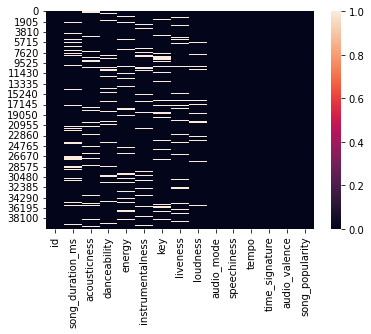

In [8]:
sns.heatmap(train.isna())

In [9]:
print(f'\033[92mNumber of rows in train data: {train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {train.shape[1]}')
print(f'\033[91mNumber of values in train data: {train.count().sum()}')
print(f'\033[91mNumber missing values in train data: {sum(train.isna().sum())}')

Number of rows in train data: 40000
Number of columns in train data: 15
Number of values in train data: 567813
Number missing values in train data: 32187


#### Column wise missing values

In [10]:
print(train.isna().sum().sort_values(ascending=False))

song_duration_ms    4101
liveness            4086
key                 4065
danceability        4026
acousticness        3992
instrumentalness    3985
energy              3975
loudness            3957
id                     0
audio_mode             0
speechiness            0
tempo                  0
time_signature         0
audio_valence          0
song_popularity        0
dtype: int64


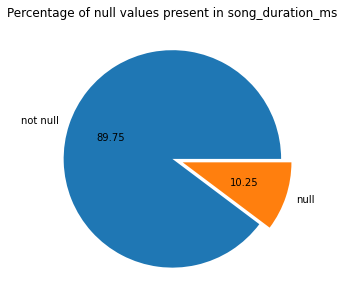

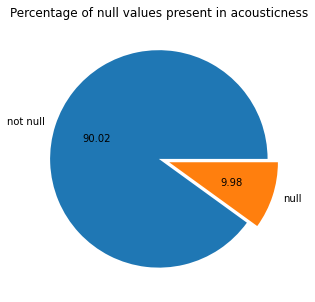

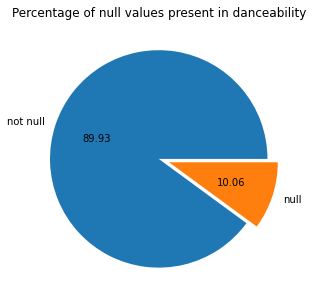

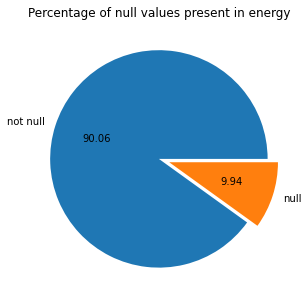

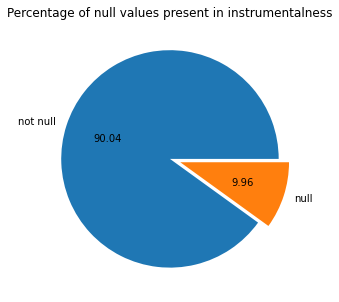

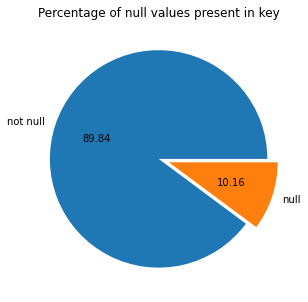

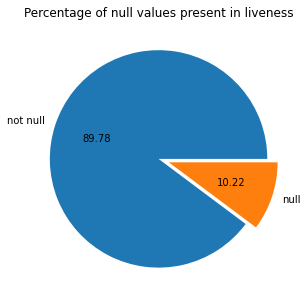

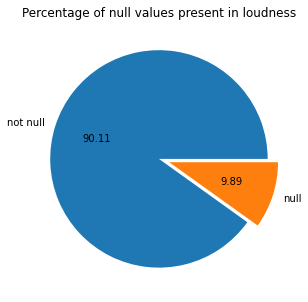

In [11]:
null_cols = [i for i in train.columns if (train[i].isnull().sum() > 0)]
tmp_data = train.copy()
total_size = 40000
for i in null_cols:
    
    plt.figure(figsize=(5, 5))
    null_values_count = train[i].isnull().sum()
    data = [total_size-null_values_count, null_values_count]
    labels = ['not null', 'null']
    explode = [0, 0.1]
    plt.title('Percentage of null values present in ' + i)
    plt.pie(data, labels=labels, autopct='%.2f', explode=explode)
    plt.show()

**We are observing nearly 10% data is missing**

#### *We not exploring test data. Since it unknown

### Dealing with missing value (reference)
Some references on how to deal with missing value:
- [Missing Values](https://www.kaggle.com/alexisbcook/missing-values) by [Alexis Cook](https://www.kaggle.com/alexisbcook)
- [Data Cleaning Challenge: Handling missing values](https://www.kaggle.com/rtatman/data-cleaning-challenge-handling-missing-values) by [Rachael Tatman](https://www.kaggle.com/rtatman)
- [A Guide to Handling Missing values in Python ](https://www.kaggle.com/parulpandey/a-guide-to-handling-missing-values-in-python) by [Parul Pandey](https://www.kaggle.com/parulpandey)
​
Some models that have capability to handle missing value by default are:
- XGBoost: https://xgboost.readthedocs.io/en/latest/faq.html
- LightGBM: https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html
- Catboost: https://catboost.ai/docs/concepts/algorithm-missing-values-processing.html

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="4"></a>
# EDA

<a id="4.1"></a>
## Overview of Data

In [12]:
train.drop(["id"] , axis = 1 , inplace = True)
test.drop(["id"] , axis = 1 , inplace = True)
TARGET = 'song_popularity'
FEATURES = [col for col in train.columns if col not in ['id', TARGET]]

### Check for Imbalanced Data

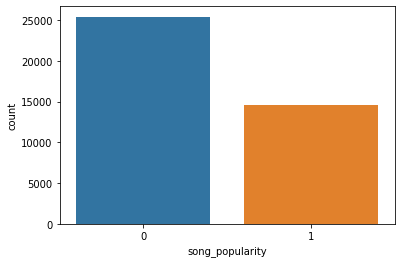

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(train['song_popularity'])
plt.show()

**Two thing which get cleared from this plot**

* Imbalanced Dataset
* Cross validation Approach will be Stratified Cross Validation

### Basic Stats of trainig data

Below is the basic statistics for each variables which contain information on `count`, `mean`, `standard deviation`, `minimum`, `1st quartile`, `median`, `3rd quartile` and `maximum`.

In [14]:
train.describe()

song_duration_ms  acousticness  danceability       energy  \
count      35899.000000  36008.000000  35974.000000 36025.000000   
mean      193165.847572      0.276404      0.570951     0.683932   
std        45822.127679      0.297928      0.190010     0.212662   
min        25658.000000     -0.013551      0.043961    -0.001682   
25%       166254.500000      0.039618      0.424760     0.539276   
50%       186660.000000      0.140532      0.608234     0.704453   
75%       215116.000000      0.482499      0.718464     0.870503   
max       491671.000000      1.065284      0.957131     1.039741   

       instrumentalness          key     liveness     loudness   audio_mode  \
count      36015.000000 35935.000000 35914.000000 36043.000000 40000.000000   
mean           0.036527     5.042605     0.198514    -7.407596     0.321150   
std            0.150024     3.372728     0.151670     3.877198     0.466924   
min           -0.004398     0.000000     0.027843   -32.117911     0.000000   
25%            0.000941     2.000000     0.111796    -9.578139     0.000000   
50%            0.001974     5.000000     0.135945    -6.345413     0.000000   
75%            0.003225     8.000000     0.212842    -4.620711     1.000000   
max            1.075415    11.000000     1.065298    -0.877346     1.000000   

       speechiness        tempo  time_signature  audio_valence  \
count 40000.000000 40000.000000    40000.000000   40000.000000   
mean      0.094107   116.562815        3.394375       0.580645   
std       0.083591    26.167911        0.524405       0.237351   
min       0.015065    62.055779        2.000000       0.013398   
25%       0.038500    96.995309        3.000000       0.398669   
50%       0.055881   113.795959        3.000000       0.598827   
75%       0.118842   128.517383        4.000000       0.759635   
max       0.560748   219.163578        5.000000       1.022558   

       song_popularity  
count     40000.000000  
mean          0.364400  
std           0.481268  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           1.000000  
max           1.000000

#### *We not exploring test data. Since it unknown

### Quick view on Submission file

In [15]:
submission.head()

id  song_popularity
0   0                0
1   1                0
2   2                0
3   3                0
4   4                0

<a id="4.2"></a>
## Continuos and Categorical Data Distribution

In [16]:
unique_arr = []
for i in train.columns:
    tmp = train[i].unique()
    if(len(tmp) <= 15):
        print(i, "---->", tmp)
        unique_arr.append(i)

key ----> [10.  8.  5.  0.  4.  3. nan  6.  2.  7.  1.  9. 11.]
audio_mode ----> [0 1]
time_signature ----> [4 3 2 5]
song_popularity ----> [0 1]


**Observations:**
- Out of 13 features `10` features are continous and `3` features are categorical.
- `key` feature has `11` differnt unique values
- `time_signature` has`4` differnt unique values.
- `audio_mode` feature is a binary cateogorical feature with `1` and `0` values.

Total number of features: 13
Number of categorical features: 3
Number of continuos features: 10


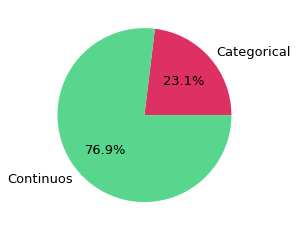

In [17]:
df = pd.concat([train[FEATURES], test[FEATURES]], axis=0)

cat_features = [col for col in FEATURES if df[col].nunique() < 15]
cont_features = [col for col in FEATURES if df[col].nunique() >= 15]

del df
print(f'Total number of features: {len(FEATURES)}')
print(f'\033[92mNumber of categorical features: {len(cat_features)}')
print(f'\033[96mNumber of continuos features: {len(cont_features)}')

plt.pie([len(cat_features), len(cont_features)], 
        labels=['Categorical', 'Continuos'],
        colors=['#DE3163', '#58D68D'],
        textprops={'fontsize': 13},
        autopct='%1.1f%%')
plt.show()

In [18]:
cat_col = [col for col in list(train.columns) if train[col].nunique()<15 if col not in ['id','song_popularity']]
num_col = [col for col in list(train.columns) if train[col].nunique()>=15 if col not in ['id','song_popularity']]
print(cat_col,num_col)

['key', 'audio_mode', 'time_signature'] ['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence']


<a id="4.3"></a>
## Feature Distribution of Continous Features

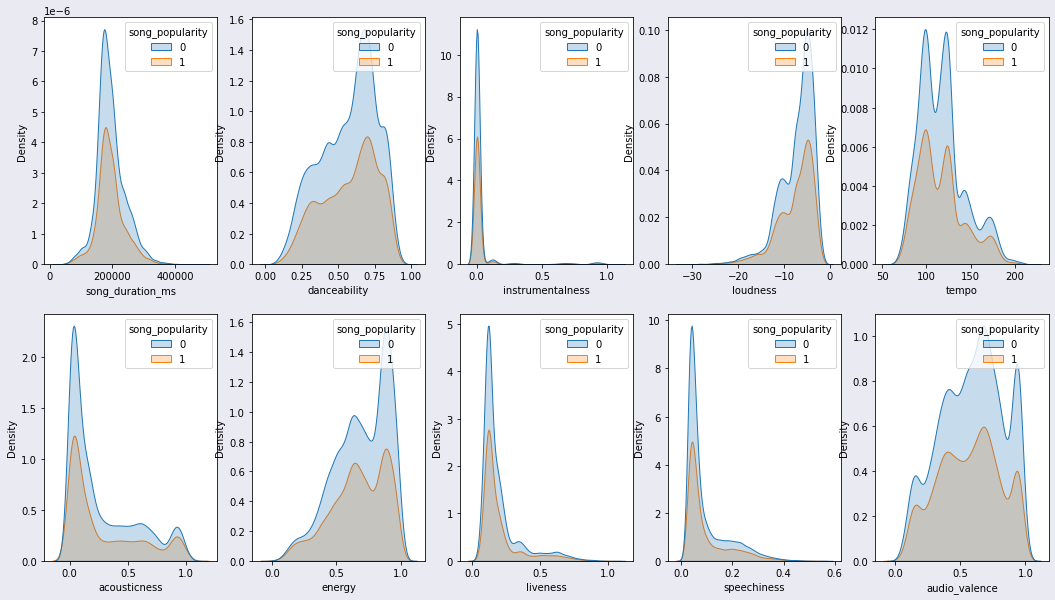

In [19]:
nrows = 2
ncols = 5
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10), facecolor='#EAEAF2')
count = 0
for c in range(5):
    for r in range(2):
        sns.kdeplot(x=num_col[count],hue='song_popularity',ax=axes[r, c],data = train,color='red', fill =True)
        count += 1
plt.show()

**1. There is no clear seperation between both the target labels with respect to the continuous features** <\n>
**2. Distributions are skewed** 


<a id="4.4"></a>
## Feature Distribution of Categorical Features

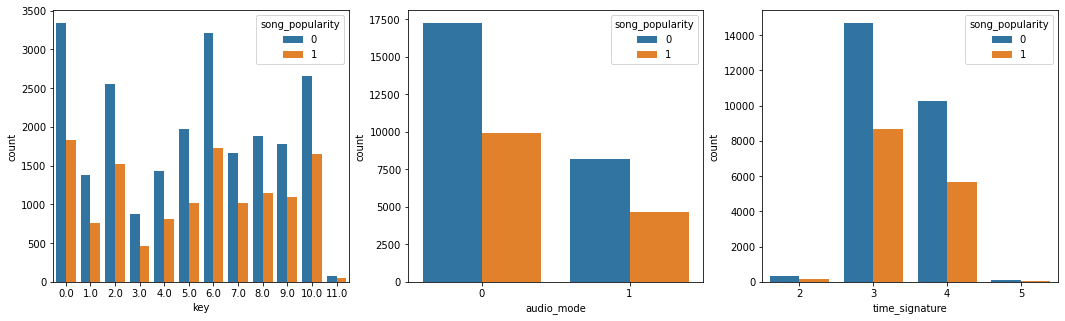

In [20]:
nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows,ncols, figsize=(18, 5))
count = 0

for r in range(nrows):
    for c in range(ncols):
        sns.countplot(x=cat_col[count],hue='song_popularity',data=train,ax=axes[c])
        count += 1
plt.show()


<a id="4.5"></a>
## Pair plot on continuious features

In [21]:
print(num_col)

['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence']


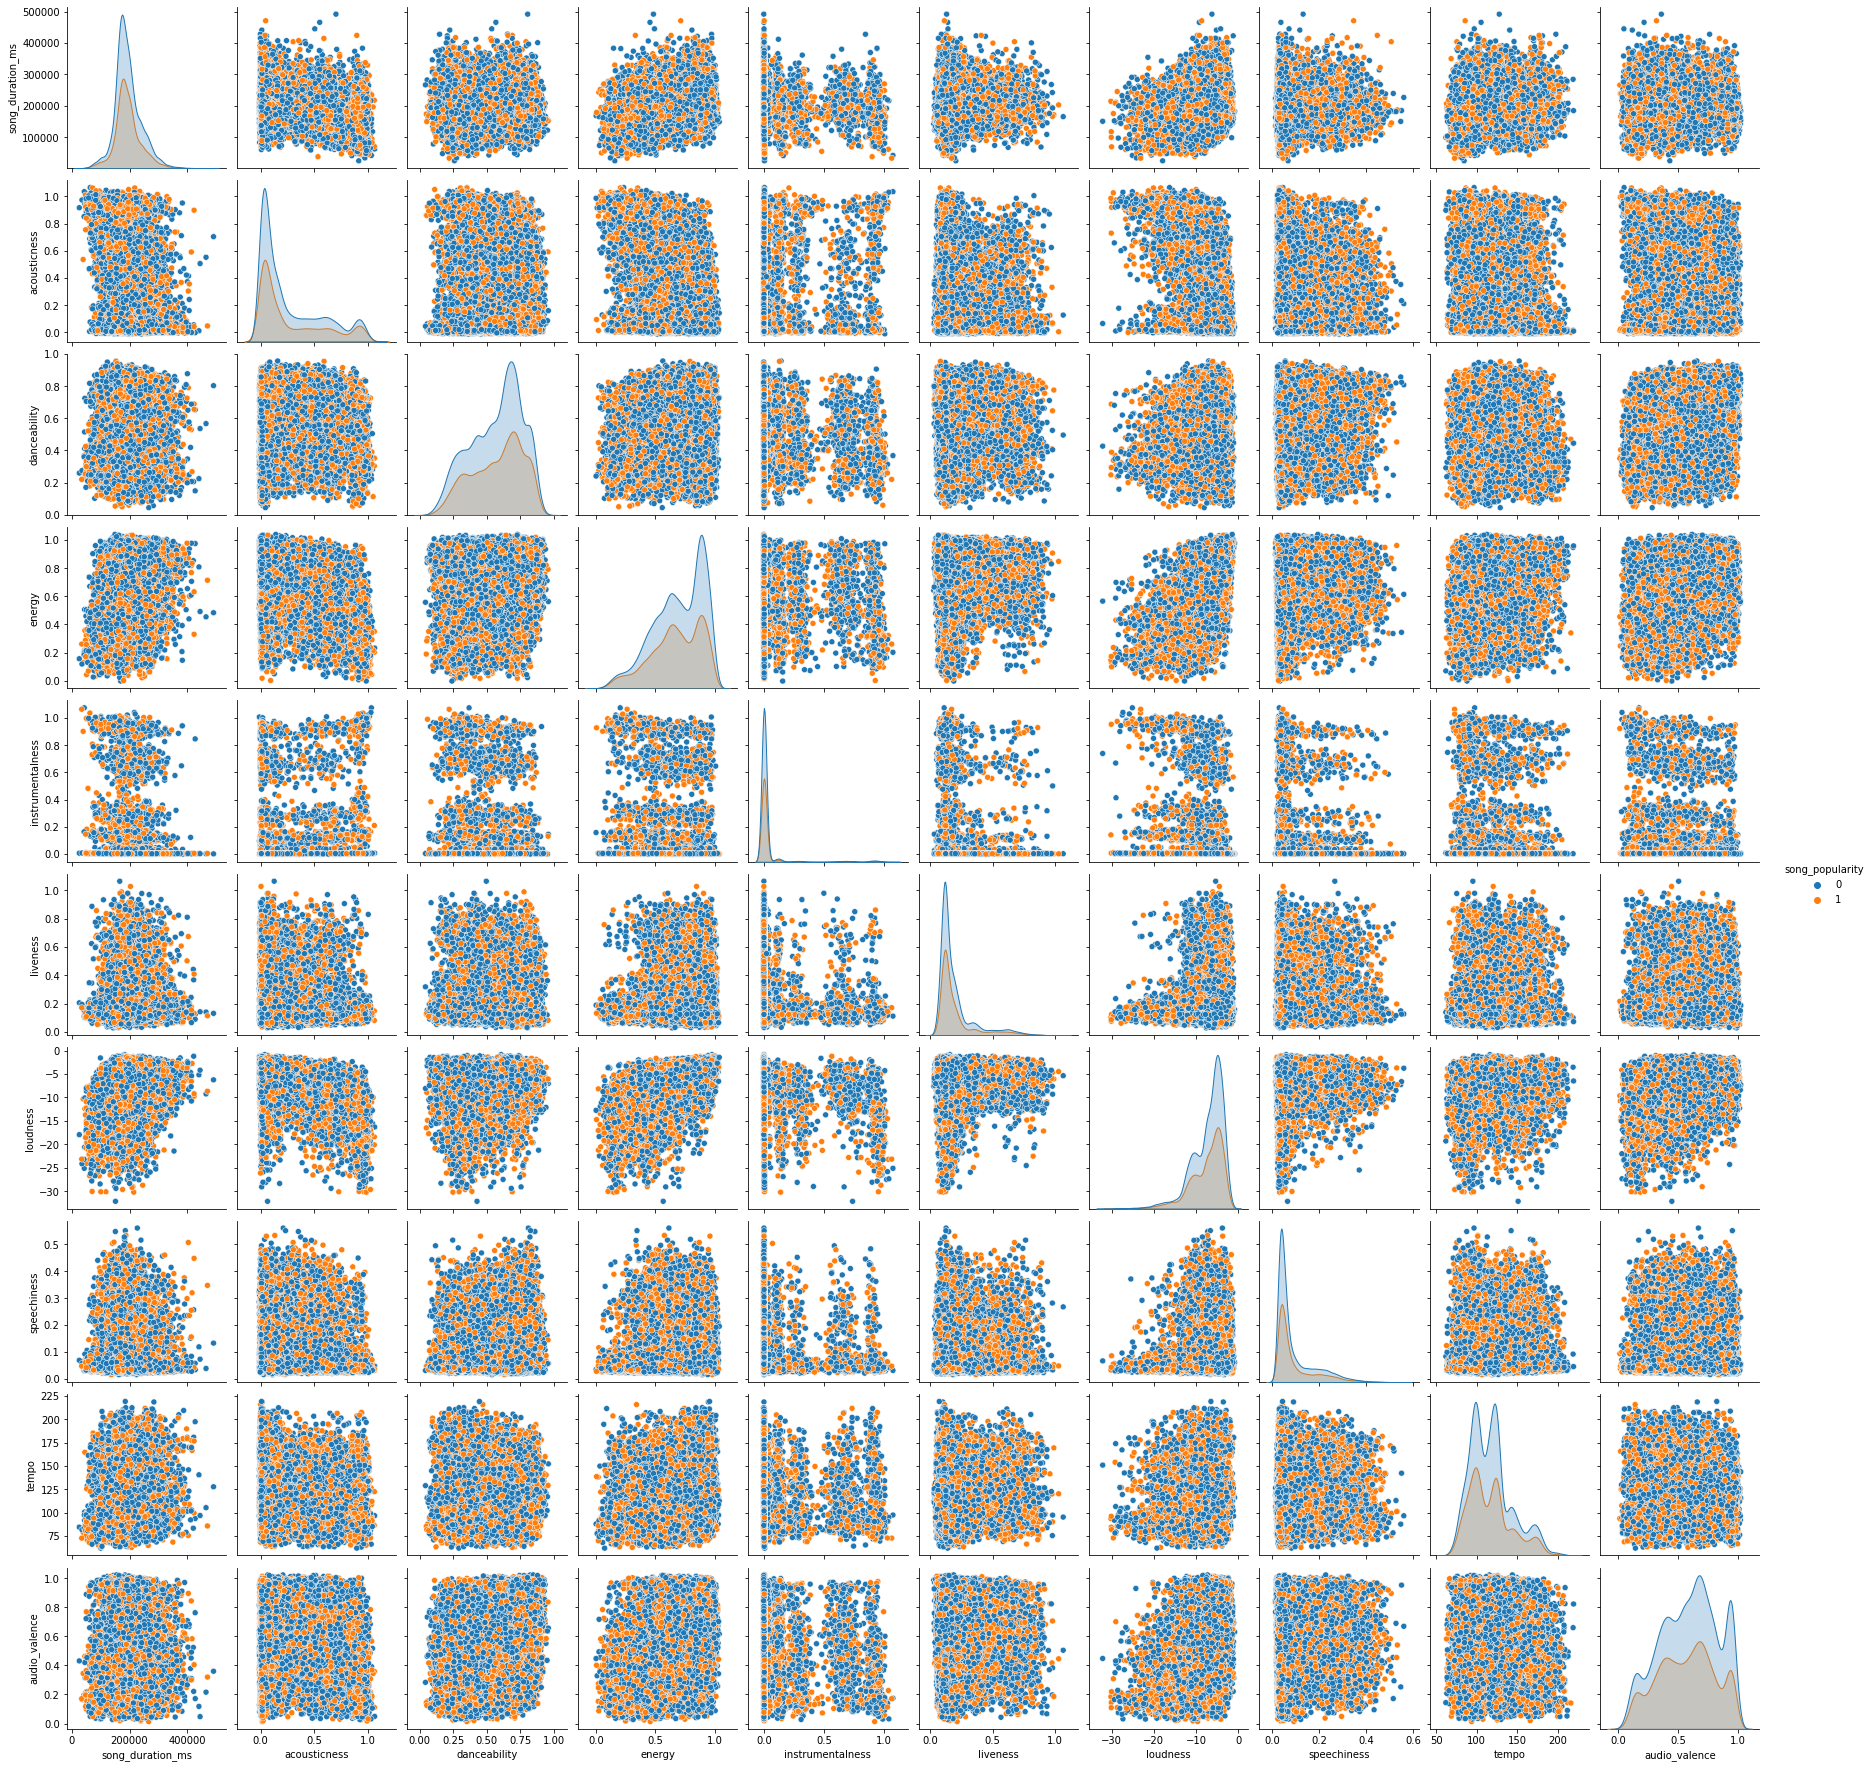

In [22]:
sns.pairplot(train,vars=num_col,hue='song_popularity')
plt.show()

**We are observing data is not lienarly seprable**

### Check for Outliers

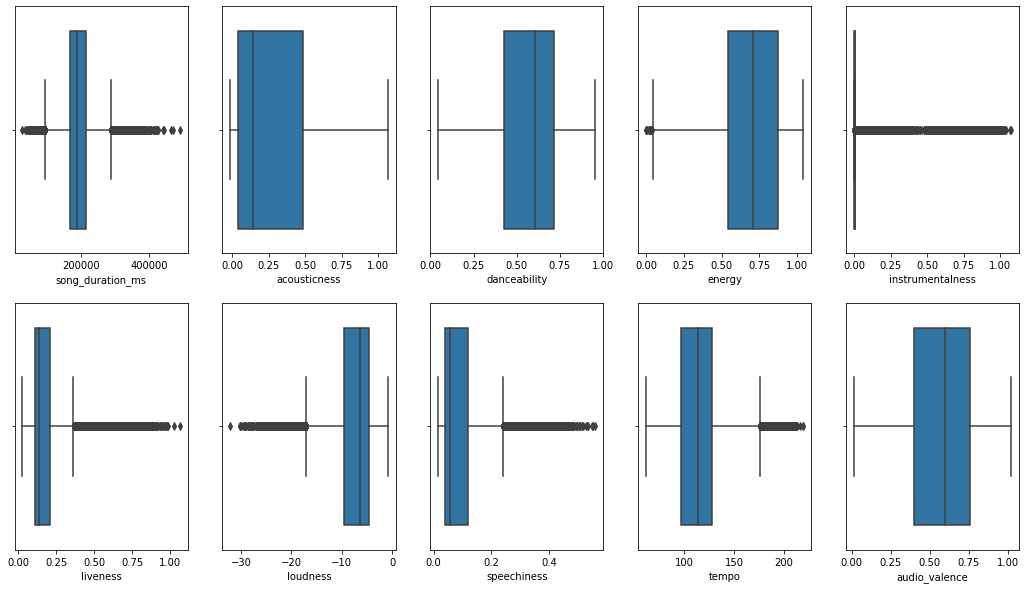

In [23]:
nrows = 2
ncols = 5
fig, axes = plt.subplots(nrows,ncols, figsize=(18, 10))
count = 0
for r in range(nrows):
    for c in range(ncols):
        sns.boxplot(x=num_col[count],data=train,ax=axes[r,c])
        count += 1
plt.show()

**Lot of Outliers in numerical columns so filling them with median for now to create the TSNE Plot**

In [24]:
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_col = num_col[:-1]
df_subset = train[num_col].copy()


imputer = SimpleImputer(strategy='median')
df_subset = imputer.fit_transform(df_subset)


scaler = StandardScaler()
df_subset = scaler.fit_transform(df_subset)


tsne = TSNE(n_components=2, verbose=0)
tsne_results = tsne.fit_transform(df_subset)

<a id="4.6"></a>
## Scatter Plot on t-SNE results

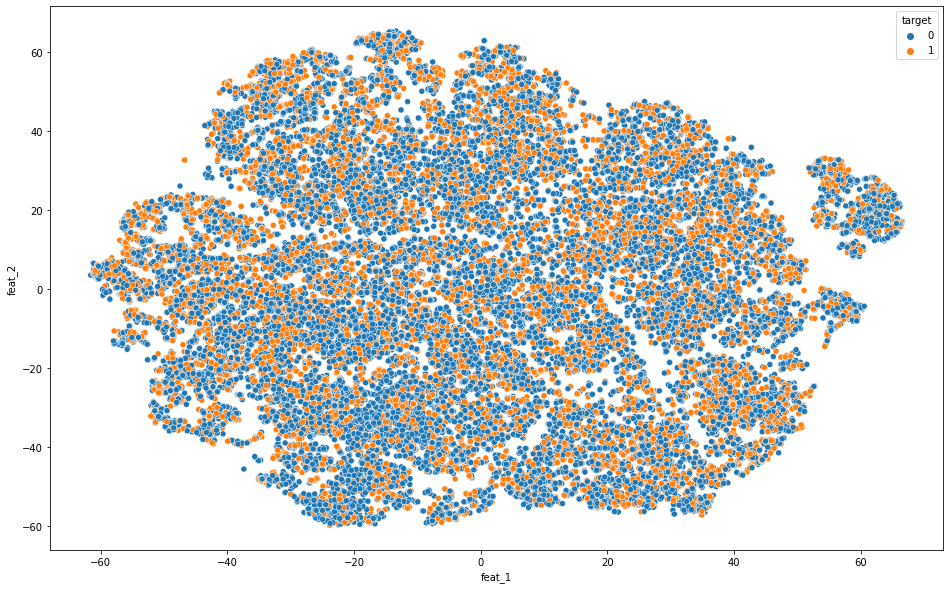

In [25]:
plot_df = pd.DataFrame({'feat_1':tsne_results[:,0],'feat_2':tsne_results[:,1],'target':train['song_popularity']})
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="feat_1", y="feat_2",
    hue="target",
    data=plot_df,
    legend="full",
    alpha=1
)
plt.show()

<a id="4.7"></a>
## Correlation matrix

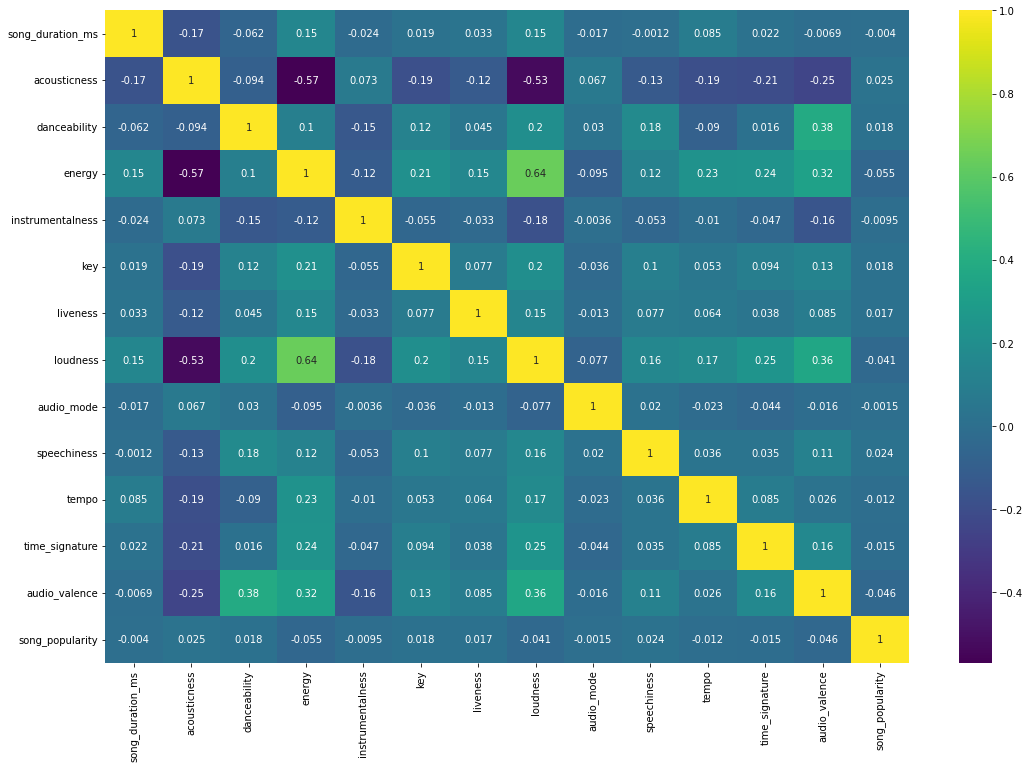

In [26]:
plt.rcParams["figure.figsize"] = (18,12)
dataplot = sns.heatmap(train.corr(), cmap="viridis", annot=True)
plt.show()

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="5"></a>
#  Modelling

# Building a Preprocessing Pipeline

Pipelines are a way to prevent train-test split contamination, keep models organized, and easily assess the performance of hyperparameter tuning and feature engineering. Additionally, if you are going to deploy models in production, such as on a cloud based server, this keeps everything organized and traceable.

**In this section I will do the following:**

<li>Define custom transformer classes to be included in the pipeline</li>
<li>Define custom helper functions to compute Root Mean Square Error (RMSE)</li>
<li>Split the training and test data</li>
<li>Define numeric and categorical features</li>
<li>Build the pipeline</li>

## Define Custom Transformers
Scikit-learn has great built-in classes for data preprocessing, like imputing missing values and normalizing features. However, sometimes we want to add preprocessing steps that don't exist or modify an existing transformers behaviour (i.e. have the output of SimpleImputer be a dataframe). We can accomplish this by defining our own custom transformers.

## Approach-1

In [29]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [30]:
numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='mean'))
      ,('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant'))
      ,('encoder', OneHotEncoder())
])

we pass a list of tuples, which is composed of (‘name’, ‘transformer’, ‘features’), to the parameter ‘transformers’.

In [37]:
from sklearn.tree import DecisionTreeClassifier
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, num_col),
   ('categorical', categorical_transformer, cat_col)
  
]) 

In [62]:
from sklearn.model_selection import train_test_split
X = train.drop('song_popularity',axis=1)
y = train['song_popularity']
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=123)

In [57]:
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor),
                ('model',DecisionTreeClassifier())
           ])

In [63]:
# Display Pipeline
from sklearn import set_config
set_config(display='diagram')
#fit data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['song_duration_ms',
                                                   'acousticness',
                                                   'danceability', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['key', 'audio_mode',
                                                   'time_signature'])])),
                ('model', DecisionTreeClassifier())])

####  Cross-Validation using Pipeline

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

params = {'model__max_depth':[1,2,3,4,5,None] }

grid = GridSearchCV(pipeline, params, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Train Score=",grid.best_score_)
results = pd.DataFrame.from_dict(grid.cv_results_)
results.sort_values('rank_test_score')[0:3]


Train Score= 0.63721875


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.040907      0.007661         0.004175        0.000249   
1       0.055705      0.003118         0.004033        0.000178   
2       0.075967      0.002343         0.004379        0.000324   

  param_model__max_depth                   params  split0_test_score  \
0                      1  {'model__max_depth': 1}           0.637188   
1                      2  {'model__max_depth': 2}           0.637188   
2                      3  {'model__max_depth': 3}           0.633594   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.637188           0.637188           0.637188           0.637344   
1           0.637188           0.637188           0.637188           0.637344   
2           0.635000           0.632656           0.636406           0.637344   

   mean_test_score  std_test_score  rank_test_score  
0         0.637219        0.000062                1  
1         0.637219        0.000062                1  
2         0.635000        0.001729                3

In [66]:
##Fetch best permaters
max_depth= grid.best_params_['model__max_depth']
print('Best depth=',max_depth)

Best depth= 1


In [72]:
y_predict = pipeline.predict(X_cv)
my_submission = pd.DataFrame({'Actual':y_cv,'Popularity': y_predict})
print(my_submission.head())

       Actual  Popularity
32566       1           0
28547       0           0
6456        1           0
33898       0           1
34403       0           0


### Exporting the Pipeline

In [74]:
# export 
import pickle
pickle.dump(pipeline,open('pipe.pkl','wb'))

### Try to Run test with out doing preprocessing using pipeline

In [76]:

y_test_pred = pipeline.predict(test)
my_submission = pd.DataFrame({'Popularity': y_test_pred})
print(my_submission.head())

   Popularity
0           1
1           1
2           0
3           0
4           0


# Refrences

#### https://www.kaggle.com/nishantsushmakar/eda-by-brown-munde
#### https://www.kaggle.com/santoshvarma/song-popularity-prediction-eda-modelling/edit
#### https://towardsdatascience.com/step-by-step-tutorial-of-sci-kit-learn-pipeline-62402d5629b6
#### https://www.analyticsvidhya.com/blog/2021/05/understanding-column-transformer-and-machine-learning-pipelines/